# scRNAseq

Heatmap of transcript levels (CPM) of inducible macrophage genes (Bhatt et al., 2012) detected by scRNA-seq.

In [1]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end

using Seaborn, PyPlot, PyCall, DataFrames
using NoLongerProblems_Pandas, Pandas
using MultipleTesting, HypothesisTests 
using SingleCellExperiment
using CSV, ProgressMeter,PrettyPlotting, ScikitLearn
@sk_import linear_model: LogisticRegression

include("../Databases/Cuartero2018.jl")
include("../Databases/Bhatt2012.jl")
include("../Databases/MF_SingleCell.jl")
include("../Code/Load_scRNAseqData.jl")

sce = SingleCellExperiment.get_cells_with_this_characteristics(["WT"], :Genotype, sce)
sce = SingleCellExperiment.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "CPM")
sce = SingleCellExperiment.fit_single_cell_logistic_regression(sce, assay = "CPM")
bhattgenes = Bhatt2012.inducible_genes_figure3()[!,:GeneSymbol];
sce = SingleCellExperiment.Shalek2014_module_score(collect(bhattgenes), sce,fitparameter = "mu", modulescore_name = :BhattGenesScore, untreated_pattern = "UT",comparedtothissample = "WT", assay = "CPM")
sce = SingleCellExperiment.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "lnCPMplus1")

bhattgenes= DataFrames.DataFrame(
    "GeneID" => Bhatt2012.inducible_genes_figure3()[!,:GeneSymbol], 
    "Class"=>Bhatt2012.inducible_genes_figure3()[!,:Class]
    );
sceBhatt = innerjoin(sce.rowData, bhattgenes,on = :GeneID)

col_colors_dict = Dict(
    "WT_UT" => "#f0f0f0",
    "WT_2H" => "#bdbdbd",
    "WT_8H" => "#636363",
    "RAD21_UT" => "#fee0d2",
    "RAD21_2H" => "#fc9272",
    "RAD21_8H" => "#de2d26",
    "RAD21" => "red",
    "WT" => "darkgrey",
    "0" => "#deebf7",
    "2" => "#9ecae1",
    "8" => "#3182bd",
    ) 

┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/irene/.julia/packages/PyPlot/XHEG0/src/init.jl:118
/Users/irene/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


Dict{String, String} with 11 entries:
  "2"        => "#9ecae1"
  "WT"       => "darkgrey"
  "RAD21_2H" => "#fc9272"
  "8"        => "#3182bd"
  "RAD21_UT" => "#fee0d2"
  "RAD21_8H" => "#de2d26"
  "0"        => "#deebf7"
  "WT_UT"    => "#f0f0f0"
  "RAD21"    => "red"
  "WT_8H"    => "#636363"
  "WT_2H"    => "#bdbdbd"

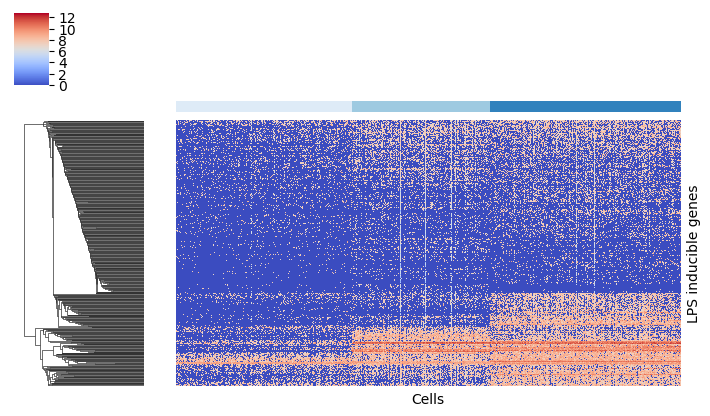

Percent 10.0%
Total genes considered 453


/Users/irene/anaconda3/lib/python2.7/site-packages/seaborn/matrix.py:626: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [2]:
sce.colData[!,"LPS"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in sce.colData[!,"Sample"]]
sce = sort_cells!(sce, cols = [ :LPS, :Genotype,:BhattGenesScore], rev = [false, true, false])
subsce = select_these_genes(bhattgenes[!,:GeneID], sce)

# Genes detected in 10%
alpha = 0.1
# Bool for 2H LPS
bool1 = subsce.rowData[!,:WT_2H__alpha].>=alpha
# Bool for 8H LPS
bool2 = subsce.rowData[!,:WT_8H__alpha].>=alpha
# Bool for either in 2H or 8H
bool = (bool1.+bool2).>0
println(string("Percent ", alpha*100, "%"))
println(string("Total genes considered ", sum(bool)))

subsubsce = filter_genes(bool,subsce)

g = Seaborn.clustermap(subsubsce.assays["lnCPMplus1"], figsize = (7, 4),yticklabels=false,xticklabels=false, col_cluster = false, col_colors = [col_colors_dict[ii] for ii in subsce.colData[!,:LPS]], cmap="coolwarm")

ax = g.ax_heatmap
ax.set_ylabel("LPS inducible genes")
ax.set_xlabel("Cells")
ax.tick_params(axis="both", which="both", length=0)

savefigwithtext("scRNAseq_heatmap_bhattgenes_WT_10percent.pdf")

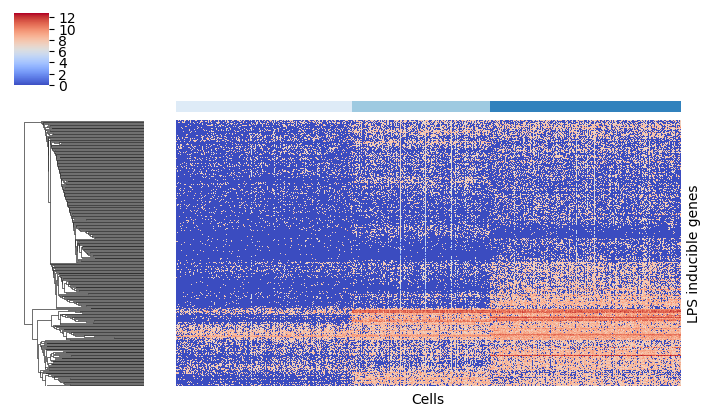

Percent 20.0%
Total genes considered 356


In [3]:
sce.colData[!,"LPS"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in sce.colData[!,"Sample"]]
sce = sort_cells!(sce, cols = [ :LPS, :Genotype,:BhattGenesScore], rev = [false, true, false])
subsce = select_these_genes(bhattgenes[!,:GeneID], sce)

# Genes detected in 20%
alpha = 0.2
# Bool for 2H LPS
bool1 = subsce.rowData[!,:WT_2H__alpha].>=alpha
# Bool for 8H LPS
bool2 = subsce.rowData[!,:WT_8H__alpha].>=alpha
# Bool for either in 2H or 8H
bool = (bool1.+bool2).>0
println(string("Percent ", alpha*100, "%"))
println(string("Total genes considered ", sum(bool)))

subsubsce = filter_genes(bool,subsce)

g = Seaborn.clustermap(subsubsce.assays["lnCPMplus1"], figsize = (7, 4),yticklabels=false,xticklabels=false, col_cluster = false, col_colors = [col_colors_dict[ii] for ii in subsce.colData[!,:LPS]], cmap="coolwarm")

ax = g.ax_heatmap
ax.set_ylabel("LPS inducible genes")
ax.set_xlabel("Cells")
ax.tick_params(axis="both", which="both", length=0)
savefigwithtext("scRNAseq_heatmap_bhattgenes_WT_20percent.pdf")

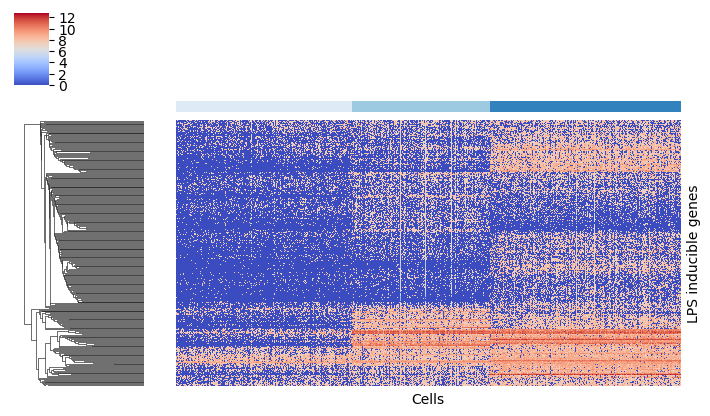

Percent 30.0%
Total genes considered 296


In [4]:
sce.colData[!,"LPS"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in sce.colData[!,"Sample"]]
sce = sort_cells!(sce, cols = [ :LPS, :Genotype,:BhattGenesScore], rev = [false, true, false])
subsce = select_these_genes(bhattgenes[!,:GeneID], sce)

# Genes detected in 30%
alpha = 0.3
# Bool for 2H LPS
bool1 = subsce.rowData[!,:WT_2H__alpha].>=alpha
# Bool for 8H LPS
bool2 = subsce.rowData[!,:WT_8H__alpha].>=alpha
# Bool for either in 2H or 8H
bool = (bool1.+bool2).>0
println(string("Percent ", alpha*100, "%"))
println(string("Total genes considered ", sum(bool)))

subsubsce = filter_genes(bool,subsce)

g = Seaborn.clustermap(subsubsce.assays["lnCPMplus1"], figsize = (7, 4),yticklabels=false,xticklabels=false, col_cluster = false, col_colors = [col_colors_dict[ii] for ii in subsce.colData[!,:LPS]], cmap="coolwarm")

ax = g.ax_heatmap
ax.set_ylabel("LPS inducible genes")
ax.set_xlabel("Cells")
ax.tick_params(axis="both", which="both", length=0)

savefigwithtext("scRNAseq_heatmap_bhattgenes_WT_30percent.pdf")

In [5]:
import Pkg
Pkg.status()

      Status `~/.julia/environments/v1.6/Project.toml`
  [336ed68f] CSV v0.9.11
  [a93c6f00] DataFrames v0.22.7
  [31c24e10] Distributions v0.23.12
  [c2308a5c] FASTX v1.2.0
  [53c48c17] FixedPointNumbers v0.8.4
  [09f84164] HypothesisTests v0.10.2
  [7073ff75] IJulia v1.23.2
  [6a3955dd] ImageFiltering v0.6.21
  [6218d12a] ImageMagick v1.2.2
  [86fae568] ImageView v0.10.13
  [916415d5] Images v0.23.3
  [96684042] InformationMeasures v0.3.1
  [4138dd39] JLD v0.12.3
  [093fc24a] LightGraphs v1.3.5
  [10e44e05] MATLAB v0.8.0
  [f8716d33] MultipleTesting v0.4.1
  [eadc2687] Pandas v1.4.0
  [91a5bcdd] Plots v1.21.2
  [92933f4c] ProgressMeter v1.5.0
  [438e738f] PyCall v1.92.2
  [d330b81b] PyPlot v2.9.0
  [6f49c342] RCall v0.13.10
  [3646fa90] ScikitLearn v0.6.3
  [d2ef9438] Seaborn v0.4.1
  [2913bbd2] StatsBase v0.33.10
